## Trajectory of a ptychographic scan

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os, sys
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2, fftshift, ifftshift

sys.path.append('../..')
from display import cm, format_axis, format_str, props, bar_format
from utils import TorchRegularGridInterpolator
from ode import ODE

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
default_type = torch.float32
torch.set_default_dtype(default_type)

In [3]:
image_dir = 'images/'
model_dir = 'models/'

if not os.path.exists(image_dir):
    os.makedirs(image_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Load time series data

In [4]:
# Create a custom ODE class for handling experimental datasets
class ODExp(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, requires_grad=True, default_type=torch.float64):
        super(ODExp, self).__init__(method, adjoint, requires_grad, default_type=default_type)
        
        default_args = {'dirname': 'Experiments/',
                        'run': 0
                       }
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        
    def load_exp(self):
        # set paths
        self.positions_path = self.dirname + 'raw/positions.csv'
        self.object_path = self.dirname + 'data/run{:g}_object_0.csv'.format(self.run)
        self.probe_path = self.dirname + 'data/run{:g}_probe_0.csv'.format(self.run)
        self.probes_path = self.dirname + 'data/run{:g}_probes_0.csv'.format(self.run)
        
        # read in detector positions and convert to um
        self.pos = pd.read_csv(self.positions_path, header=None, names=('y','x'))
        self.pos.x *= 1e6
        self.pos.y *= 1e6
        self.points = torch.tensor(np.array([self.pos.x, self.pos.y]).T, dtype=self.default_type)
        self.points = nn.Parameter(self.points.reshape(-1,1,1,2), requires_grad=False)
        ic, ii = (self.pos.x**2 + self.pos.y**2).argsort()[:2]
        self.xc, self.yc = self.pos.x[ic], self.pos.y[ic]
        self.xi, self.yi = self.pos.x[ii], self.pos.y[ii]
        
        # read object
        self.obj = torch.from_numpy(np.genfromtxt(self.object_path, delimiter=',', dtype=np.complex64))
        self.obj = nn.Parameter(self.obj, requires_grad=False)
        
        # read probe
        self.probe = torch.from_numpy(np.genfromtxt(self.probe_path, delimiter=',', dtype=np.complex64))
        self.probes = torch.from_numpy(np.genfromtxt(self.probes_path, delimiter=',', dtype=np.complex64))
        
        # real space grid
        self.p = 6.82e-3 # object and probe pixel lengths (um)
        h, w = self.obj.shape
        self.L = max(self.p*h, self.p*w)
        self.obj_x = self.p*torch.arange(w, dtype=self.default_type)
        self.obj_y = self.p*torch.arange(h, dtype=self.default_type)
        self.obj_x -= self.obj_x.mean()
        self.obj_y -= self.obj_y.mean()
        self.obj_x = nn.Parameter(self.obj_x, requires_grad=False)
        self.obj_y = nn.Parameter(self.obj_y, requires_grad=False)
        self.obj_X, self.obj_Y = torch.meshgrid(self.obj_x, self.obj_y, indexing='xy')
        self.f_obj = TorchRegularGridInterpolator((self.obj_y, self.obj_x), self.obj)
        
        h, w = self.probe.shape
        self.probe_x = self.p*torch.arange(w, dtype=self.default_type)
        self.probe_y = self.p*torch.arange(h, dtype=self.default_type)
        self.probe_x -= self.probe_x.mean()
        self.probe_y -= self.probe_y.mean()
        self.probe_X, self.probe_Y = torch.meshgrid(self.probe_x, self.probe_y, indexing='xy')
        self.probe_X = nn.Parameter(self.probe_X, requires_grad=False)
        self.probe_Y = nn.Parameter(self.probe_Y, requires_grad=False)
        
        self.probes = self.probes.reshape(-1,h,w)
        self.probes = nn.Parameter(self.probes, requires_grad=False)
        
        # read data
        self.data = np.zeros((len(self.pos),512,512))
        for i in tqdm(range(len(self.pos)), bar_format=bar_format, desc='Parse data'):
            self.data[i] = np.fromfile(self.dirname + 'raw/image_{:06d}.bin'.format(i),
                                       dtype=np.float32).reshape(h,w)
        self.data = torch.tensor(self.data, dtype=self.default_type)
        
    
    def get_batch(self, batch_time, batch_size, max_time=np.inf):
        T, M, _, D = self.y.shape
        T = min(max_time, T)
        
        if batch_time == T:
            b = np.random.choice(M, batch_size, replace=False)
            return self.t[:T], self._y[0,b], self._y[:T,b], self.y[:T,b], self._i[:T,b]
        
        else:
            t_batch = self.t[:batch_time]

            c = [[i,j] for i in range(T - batch_time) for j in range(M)]
            b = [c[i] for i in np.random.choice(len(c), batch_size, replace=False)]

            for i in range(len(b)):
                if i==0:
                    y0_batch = self._y[b[i][0], b[i][1]][None,:]
                    y_batch = torch.stack([self._y[b[i][0]+j, b[i][1]] for j in range(batch_time)], dim=0)[:,None,:]
                    yt_batch = torch.stack([self.y[b[i][0]+j, b[i][1]] for j in range(batch_time)], dim=0)[:,None,:]
                    i_batch = torch.stack([self._i[b[i][0]+j, b[i][1]] for j in range(batch_time)], dim=0)[:,None]
                else:
                    y0_batch = torch.cat((y0_batch, self._y[b[i][0], b[i][1]][None,:]))
                    y_batch = torch.cat(
                        (y_batch, torch.stack([self._y[b[i][0]+j, b[i][1]] for j in range(batch_time)],
                                              dim=0)[:,None,:]), dim=1)
                    yt_batch = torch.cat(
                        (yt_batch, torch.stack([self.y[b[i][0]+j, b[i][1]] for j in range(batch_time)],
                                               dim=0)[:,None,:]), dim=1)
                    i_batch = torch.cat(
                        (i_batch, torch.stack([self._i[b[i][0]+j, b[i][1]] for j in range(batch_time)],
                                              dim=0)[:,None]), dim=1)
            return t_batch, y0_batch, y_batch, yt_batch, i_batch

    
    def get_path(self):
        self._i = torch.zeros(self.y.shape[:2], dtype=int)
        self._y = torch.zeros_like(self.y)
        self._y[...,-1] = self.y[...,-1].clone()
        for i in range(len(self.y)):
            self._i[i] = torch.square(self.y[[i],...,:2] - self.points).sum(dim=-1).argmin()
            self._y[i,...,:2] = self.points[self._i[i]]
        
        
    def cxs(self, y):
        # Compute CXS intensity as square modulus of FFT
        y = y.unsqueeze(-2)
        p = self.f_obj((self.probe_Y + y[...,[1]], self.probe_X + y[...,[0]]))*self.probes
        th = (y[...,:2]**2).sum(dim=-1, keepdims=True) < (self.L/2.)**2
        return fftshift(torch.abs(fft2(ifftshift(th*p)))**2).sum(dim=-3)

In [5]:
# Custom class for the true probe trajectory    
class Spiral(ODExp):
    def __init__(self, args, method='dopri5', default_type=torch.float64):
        super(Spiral, self).__init__(args, method, adjoint=False, requires_grad=False, default_type=default_type)
        
        default_args = {'w': 4.
                       }
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        self.dt = nn.Parameter(torch.tensor(1.), requires_grad=False)
        
        
    def init_state(self, *y0):
        self.y0 = nn.Parameter(torch.tensor(y0, dtype=self.default_type).view(1,1,-1), requires_grad=False)
        
       
    def forward(self, t, y):
        _x, _y, _z = y.split([1,1,1], dim=-1)
        dz = torch.tile(self.dt, _z.shape)
        dx = 0.5/torch.sqrt(_z)*((_x - self.xc)/torch.sqrt(_z) - self.w*(_y - self.yc))
        dy = 0.5/torch.sqrt(_z)*((_y - self.yc)/torch.sqrt(_z) + self.w*(_x - self.xc))
        return torch.cat([dx, dy, dz], dim=-1)

In [6]:
method = 'dopri5'
adjoint = False
nexp = '811'
args = {'dirname': '../../../../Experiments/' + nexp + '/',
        'run': 0,
        'w': 4.
       }

scan = Spiral(args, method, default_type)
scan.load_exp()
scan.init_state((1.2147464, 2.012347e-2, 593.))
scan.to(device)

t = torch.arange(593, 756, 1, dtype=default_type)
scan.solve(t, device=device)

Parse data: 100%|██████████| 963/963 [00:00<00:00, 1818.50it/s]                   


Elapsed time: 0.29 s


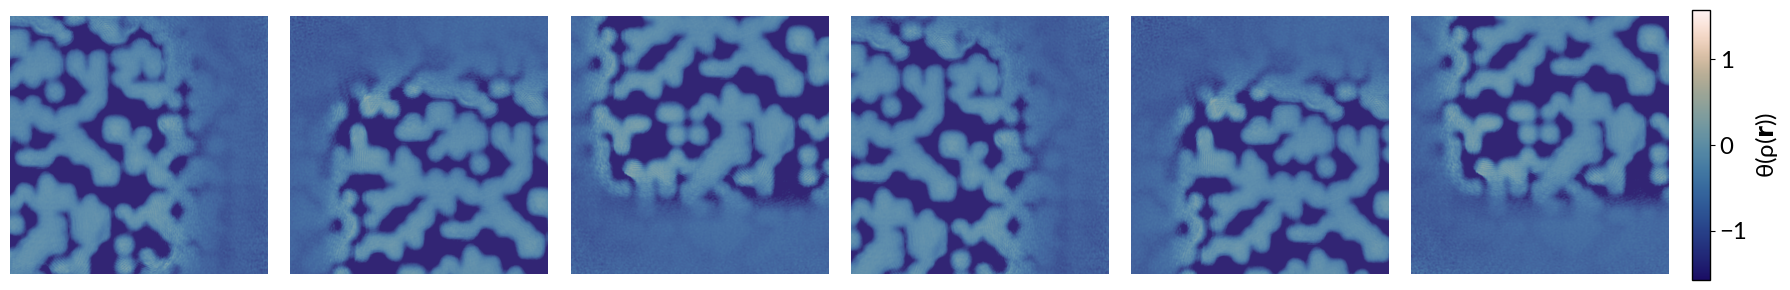

In [7]:
ymin, ymax = -np.pi/2., np.pi/2.
fig = scan.plot_series(scan.f_obj((scan.probe_Y + scan.y[::len(t)//6,...,1],
                                   scan.probe_X + scan.y[::len(t)//6,...,0])).angle(),
                       ntype=None, vmin=ymin, vmax=ymax, clabel=r'$\theta(\rho(\mathbf{r}))$')

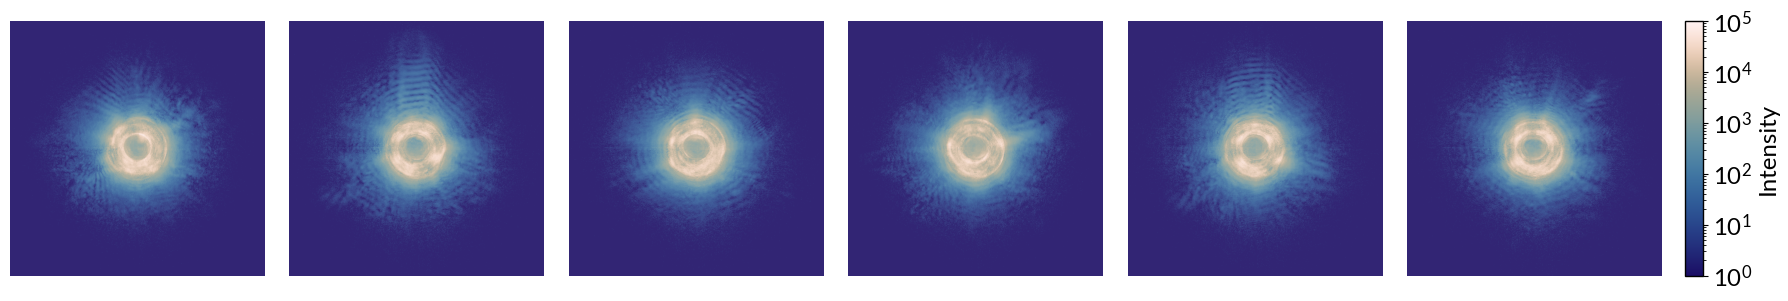

In [8]:
Y = scan.cxs(scan.y[::len(t)//6])
vmax_log = np.log10(Y.max().cpu().item())
vmax = 10**np.ceil(vmax_log)
vmin = 10**np.ceil(vmax_log - 5)
fig = scan.plot_series(Y[:,0], ntype='log', vmin=vmin, vmax=vmax, clabel='Intensity')
fig._localaxes[-1].locator_params(axis='y', numticks=vmax_log+2)

In [9]:
# Select frames for trajectory
scan.get_path()

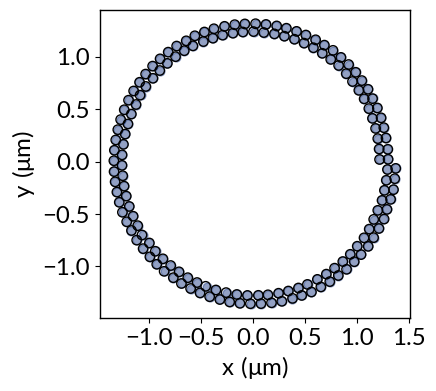

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(*scan.y[...,:2].cpu().numpy().T, color=cm.lapaz(50), s=40, alpha=0.5)
ax.scatter(*scan._y[...,:2].cpu().numpy().T, fc='none', ec='black', s=46)
format_axis(ax, props, r'$x\ (\mu m)$', r'$y\ (\mu m)$')

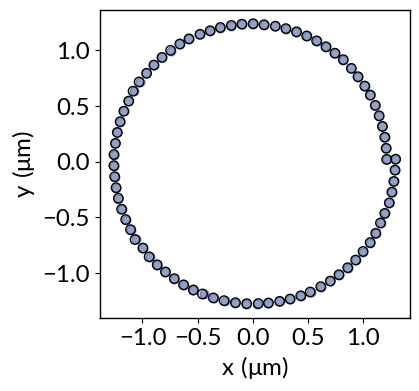

In [11]:
# Reserve portion of path for inference only
max_time = 80
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(*scan.y[:max_time,...,:2].cpu().numpy().T, color=cm.lapaz(50), s=40, alpha=0.5)
ax.scatter(*scan._y[:max_time,...,:2].cpu().numpy().T, fc='none', ec='black', s=46)
format_axis(ax, props, r'$x\ (\mu m)$', r'$y\ (\mu m)$')

In [12]:
batch_time = 20
batch_size = 5
t_batch, y0_batch, y_batch, yt_batch, i_batch = scan.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)
print('yt:', yt_batch.shape)
print(' i:', i_batch.shape)

 t: torch.Size([20])
y0: torch.Size([5, 1, 3])
 y: torch.Size([20, 5, 1, 3])
yt: torch.Size([20, 5, 1, 3])
 i: torch.Size([20, 5])


In [13]:
scan.cxs(y_batch)
t1 = time.time()
Y_batch = scan.cxs(y_batch)
t2 = time.time()
print('Elapsed time: {:.3f} s'.format(t2 - t1))

Elapsed time: 0.042 s


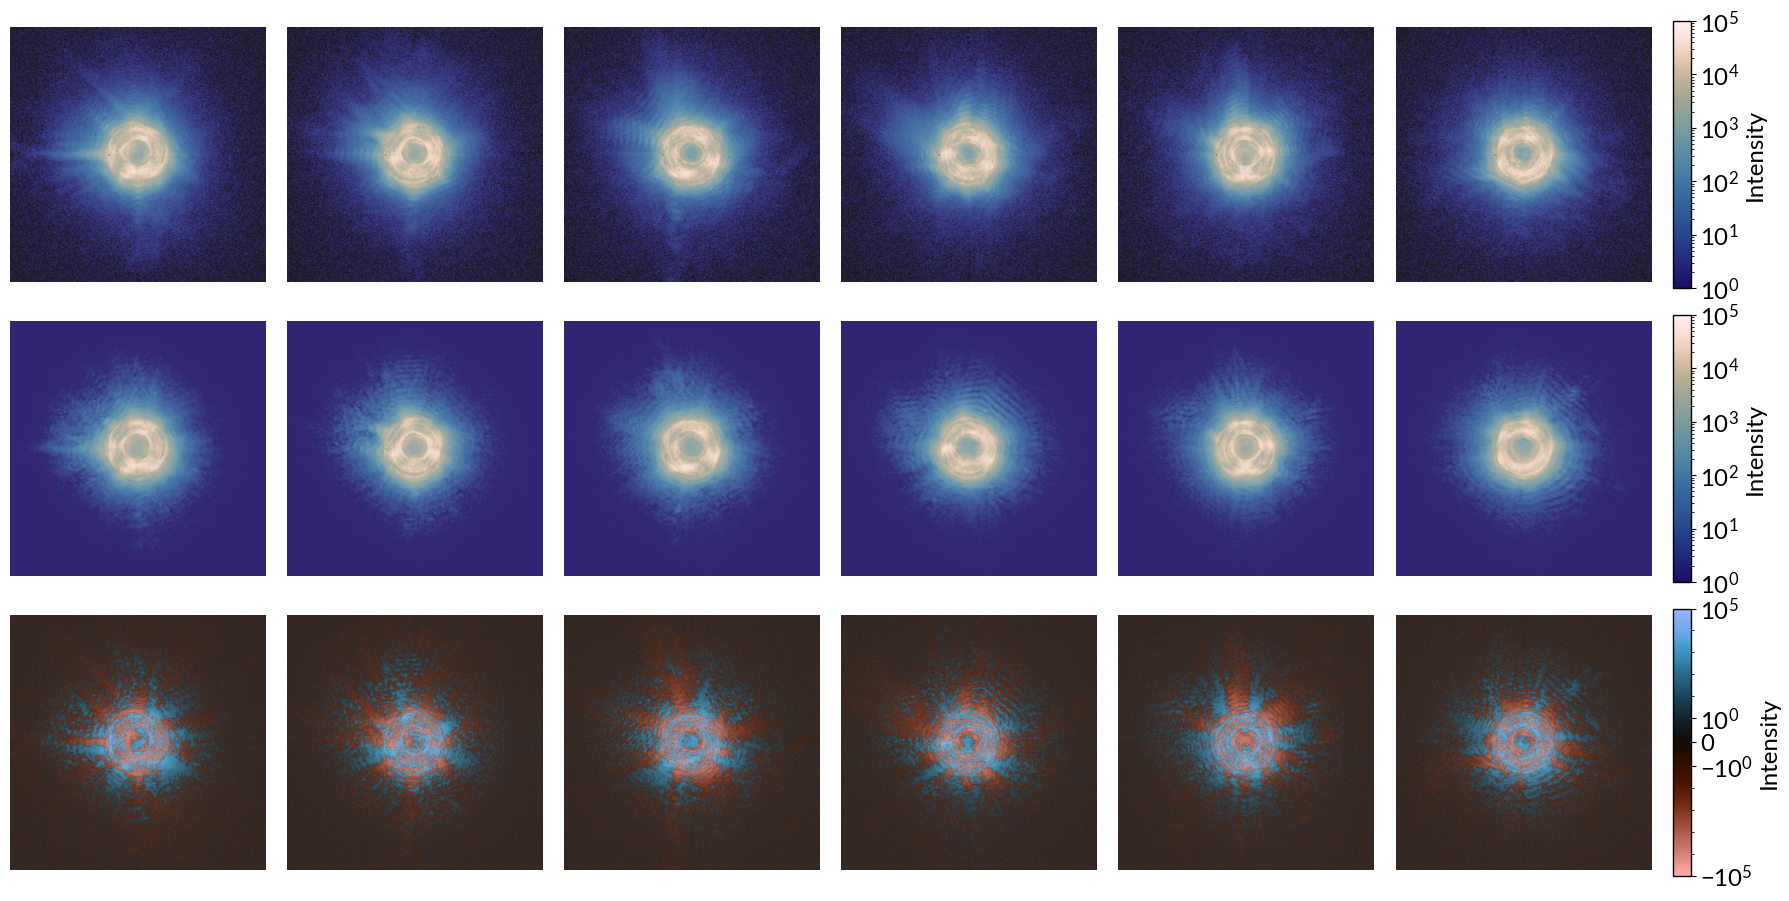

In [14]:
fig = scan.plot_series([scan.data[i_batch][:,0], Y_batch[:,0], Y_batch[:,0] - scan.data[i_batch][:,0].to(device)],
                       ntype=['log', 'log', 'symlog'], vmin=vmin, vmax=vmax, clabel='Intensity')
fig._localaxes[-8].locator_params(axis='y', numticks=vmax_log+2)
fig._localaxes[-15].locator_params(axis='y', numticks=vmax_log+2)

### Define neural ODE model

In [15]:
class NODE(ODExp):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(args, method, adjoint, requires_grad=True, default_type=default_type)

        self.Fz = nn.Sequential(
            nn.Linear(1,32),
            nn.Tanh(),
            nn.Linear(32,32),
            nn.Tanh(),
            nn.Linear(32,1)
        )

        self.F = nn.Sequential(
            nn.Linear(3,32),
            nn.Tanh(),
            nn.Linear(32,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,32),
            nn.Tanh(),
            nn.Linear(32,2)
        )
        
        self.dt = nn.Parameter(torch.tensor(1., dtype=default_type), requires_grad=False)
    
    
    def loss(self, y_true, y_pred):
        return nn.L1Loss()(y_true, y_pred)
        
        
    def forward(self, t, y):
        _y, _z = y.split([2,1], dim=-1)
        _z = self.Fz(_z)
        dy = self.F(torch.cat([_y, _z], dim=-1))
        dz = torch.tile(self.dt, y[...,[0]].shape)
        return torch.cat([dy, dz], dim=-1)

In [16]:
method = 'dopri5'
adjoint = False
args = {'dirname': '../../../../Experiments/' + nexp + '/',
        'run': 0
       }

node = NODE(args, method, adjoint, default_type).to(device)
optimizer = optim.Adam(node.parameters(), lr=3e-4)
print(node)

NODE(
  (Fz): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (F): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): Tanh()
    (10): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [17]:
image_path = image_dir + nexp + '/'
model_path = model_dir + nexp + '.torch'
    
print(image_path)
print(model_path)

images/811/
models/811.torch


### Train model

In [18]:
exp_keys = ["points", "obj", "obj_x", "obj_y", "probe_X", "probe_Y", "probes"]

try: saved = torch.load(model_path)
except:
    chkpt = 5
    loss = []
else:
    chkpt = saved['chkpt']
    loss = saved['loss']
    node.load_state_dict(saved['state'])
    node.to(device)
    optimizer.load_state_dict(saved['optimizer'])
    
node.load_exp()

Parse data: 100%|██████████| 963/963 [00:00<00:00, 1846.61it/s]                   


In [ ]:
node.train()
max_iters = 100
max_time = 80
batch_time = 35
batch_size = 5
#optimizer.param_groups[0]['lr'] /= 2.

end = time.time()
for k in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    t_batch, y0_batch, y_batch, yt_batch, i_batch = scan.get_batch(batch_time, batch_size, max_time)
    y_pred = node.solve(t_batch, y0_batch, device)
    _loss = node.loss(node.data[i_batch].to(device), node.cxs(y_pred))
    
    _loss.backward()
    optimizer.step()

    if k % chkpt == 0:
        with torch.no_grad():
            loss.append(_loss.item())
            print('Iteration: {:04d} | Total Loss: {:.6f} | Time: {:.6f}'.format(k, _loss.item(), time.time() - end))

    end = time.time()

In [ ]:
if not os.path.exists(image_path):
    os.makedirs(image_path)
    
torch.save({
    'state': {k: v for (k,v) in node.state_dict().items() if k not in exp_keys}, #node.state_dict(),
    'optimizer': optimizer.state_dict(),
    'chkpt': chkpt,
    'loss': loss,
}, model_path)

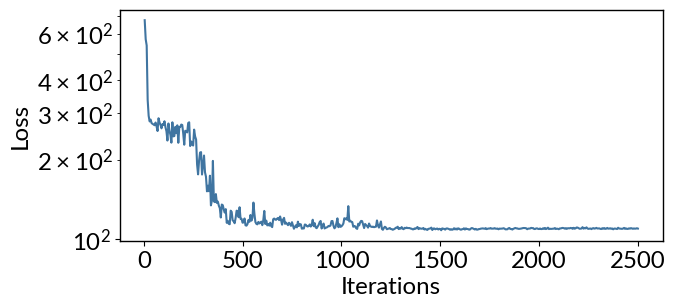

In [19]:
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(chkpt*np.arange(1,len(loss)+1), loss, color=cm.lapaz(100))
ax.set_yscale('log')
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
format_axis(ax, props, 'Iterations', 'Loss', ybins=4)

#fig.savefig(image_path + 'traj_history.svg', bbox_inches='tight', transparent=True)

### Evaluate model

In [20]:
node.eval()
batch_time = len(scan.t)
i_eval = np.array([0,20,40,80,120,160])
t_eval = np.round(scan.t[i_eval].numpy()).astype(int)

with torch.no_grad():
    t_batch, y0_batch, y_batch, yt_batch, i_batch = scan.get_batch(batch_time, 1, batch_time)
    y_pred = node.solve(t_batch, y0_batch, device)
    
    x_pred = node.f_obj((node.probe_Y + y_pred[:,[0],:,1], node.probe_X + y_pred[:,[0],:,0])).angle()
    x_batch = node.f_obj((node.probe_Y + y_batch[:,[0],:,1], node.probe_X + y_batch[:,[0],:,0])).angle()
    x_diff = x_pred - x_batch
    
    Y_pred = node.cxs(y_pred[:,0])
    Yt_batch = node.cxs(yt_batch[:,0])
    Y_batch = node.cxs(y_batch[:,0])
    Y_data = node.data[i_batch[:,0]]
    Y_diff = Y_pred - Y_data.to(device)

Elapsed time: 0.84 s


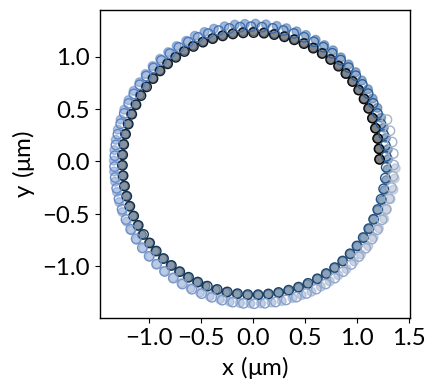

In [21]:
fig, ax = plt.subplots(figsize=(4,4))
norm = plt.Normalize(vmin=0, vmax=1.3*batch_time)
ax.scatter(*y_batch.squeeze()[:,:2].cpu().numpy().T, s=40, color=cm.oslo(norm(range(batch_time))), alpha=0.5)
ax.scatter(*y_pred.squeeze()[:,:2].cpu().numpy().T, s=46, ec=cm.oslo(norm(range(batch_time))), fc='none')
format_axis(ax, props, r'$x\ (\mu m)$', r'$y\ (\mu m)$')

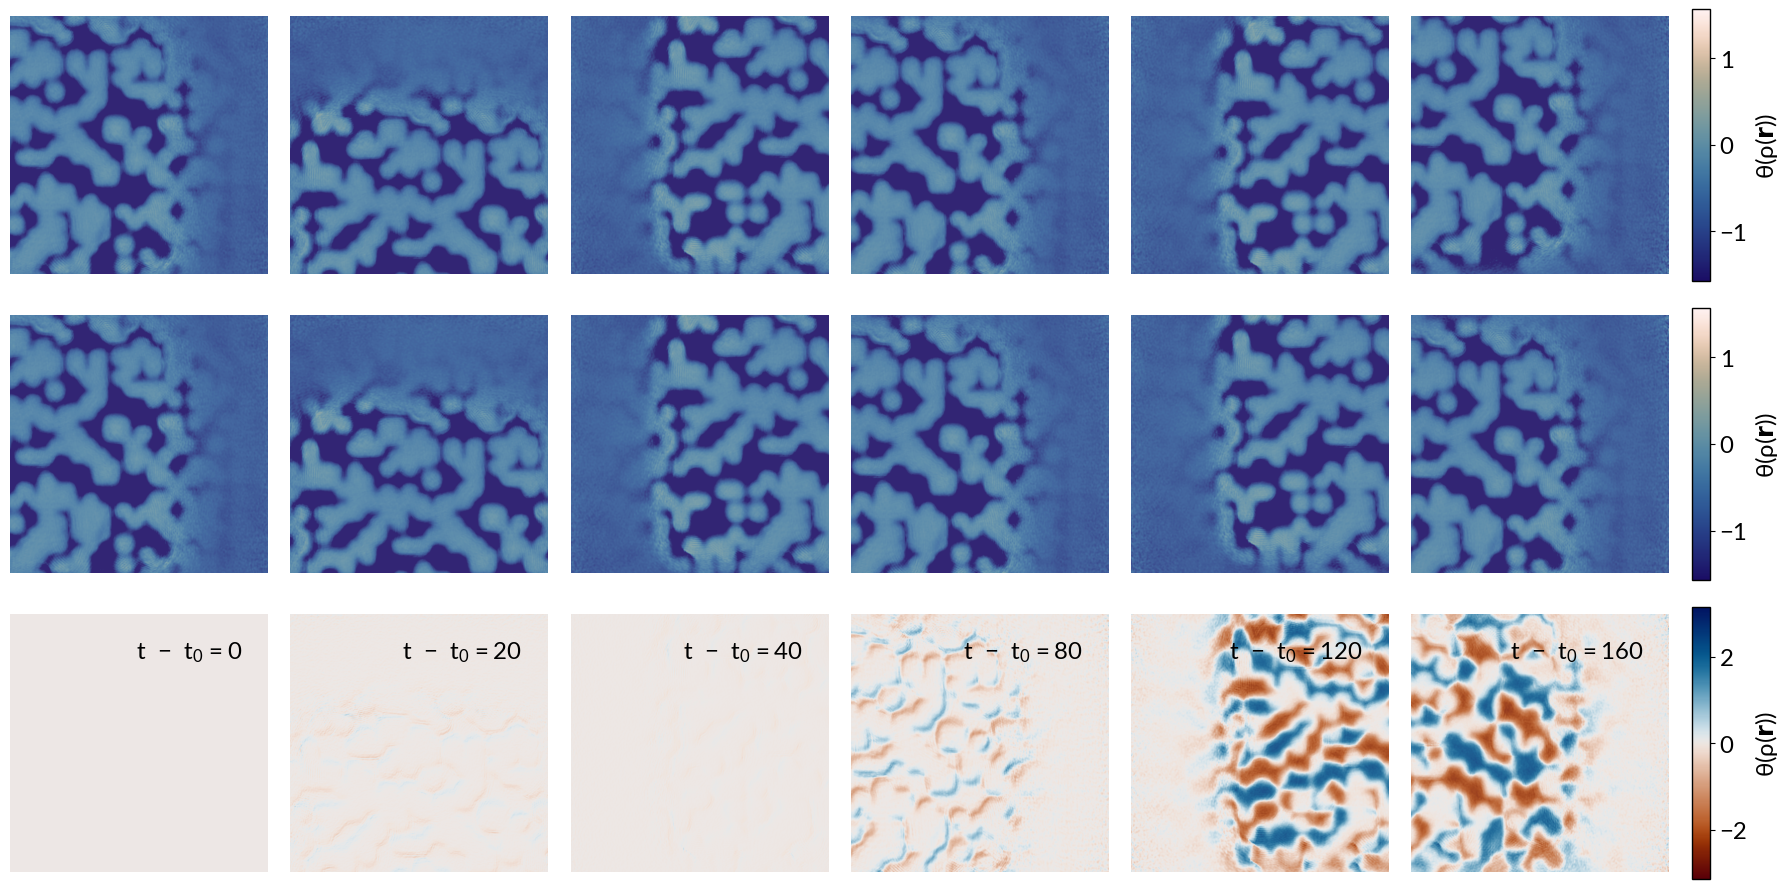

In [22]:
fig = node.plot_series([x_batch[i_eval], x_pred[i_eval], x_diff[i_eval]], ntype=[None,None,'sym'],
                       vmin=ymin, vmax=ymax, clabel=r'$\theta(\rho(\mathbf{r}))$')
for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, r'$t\ -\ t_0$ = ' + str(t_eval[i] - t_eval[0]), color='black', ha='right', va='top',
            fontproperties=props, transform=ax.transAxes)
#fig.savefig(image_path + 'traj_real.png', dpi=400, bbox_inches='tight', transparent=True)

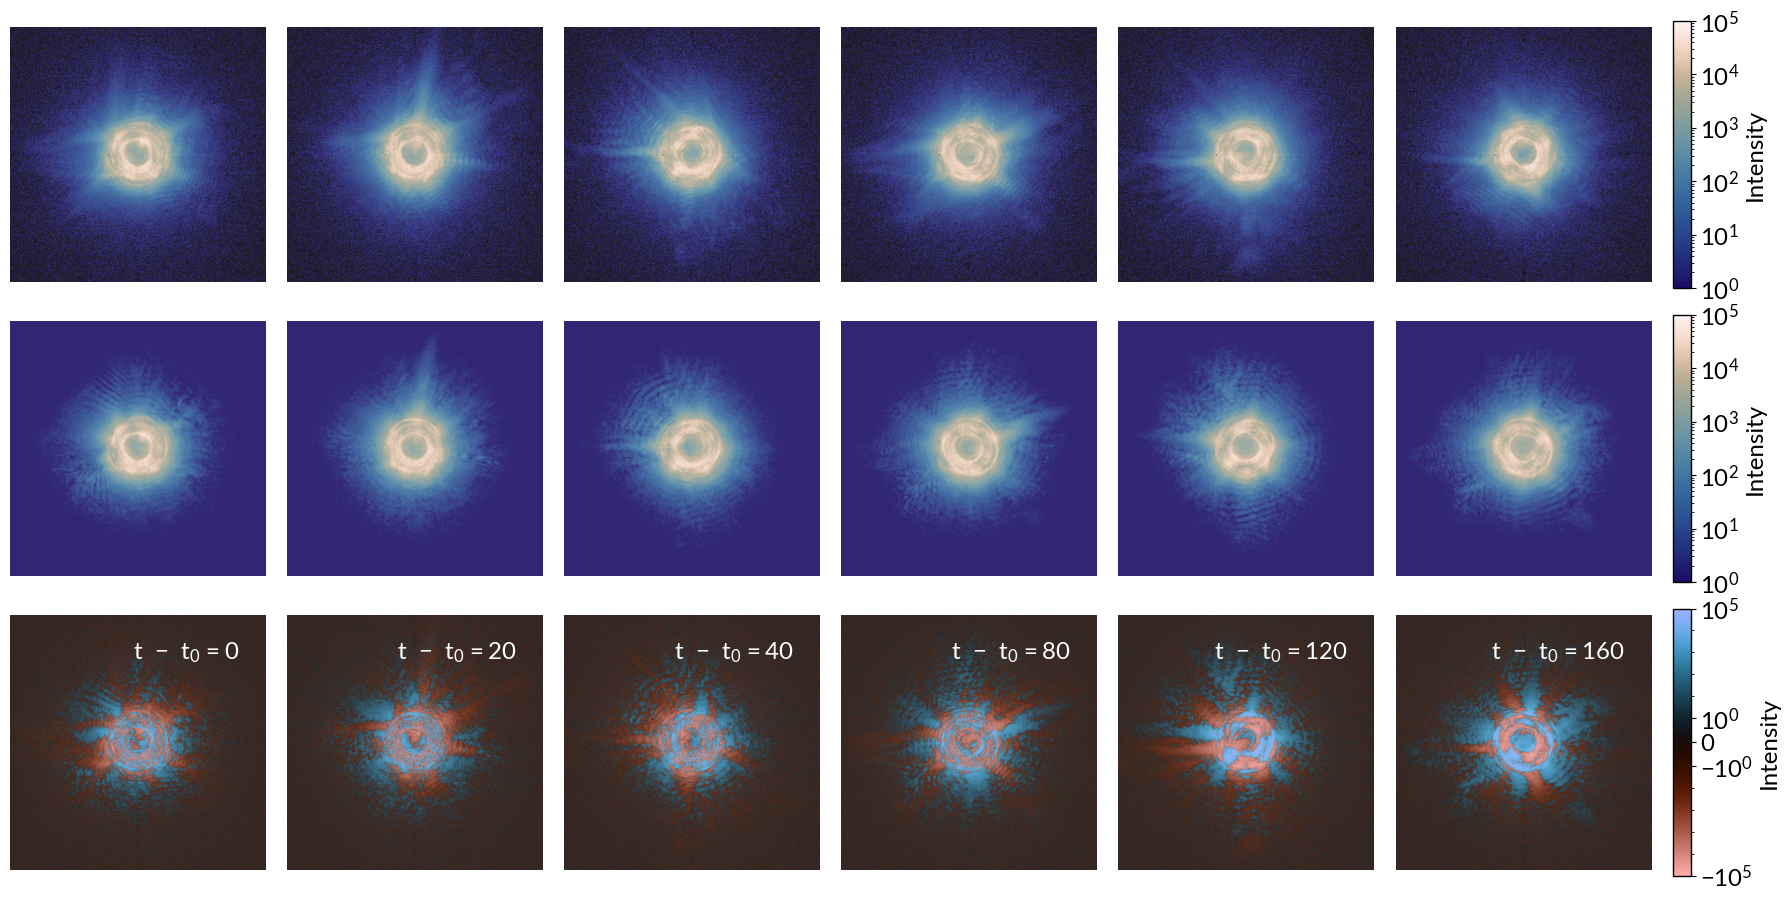

In [23]:
fig = node.plot_series([Y_data[i_eval], Y_pred[i_eval], Y_diff[i_eval]], ntype=['log', 'log', 'symlog'],
                       vmin=vmin, vmax=vmax, clabel='Intensity')
for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, r'$t\ -\ t_0$ = ' + str(t_eval[i] - t_eval[0]), color='white', ha='right', va='top',
            fontproperties=props, transform=ax.transAxes)
fig._localaxes[-8].locator_params(axis='y', numticks=vmax_log+2)
fig._localaxes[-15].locator_params(axis='y', numticks=vmax_log+2)
#fig.savefig(image_path + 'traj_fourier.png', dpi=400, bbox_inches='tight', transparent=True)

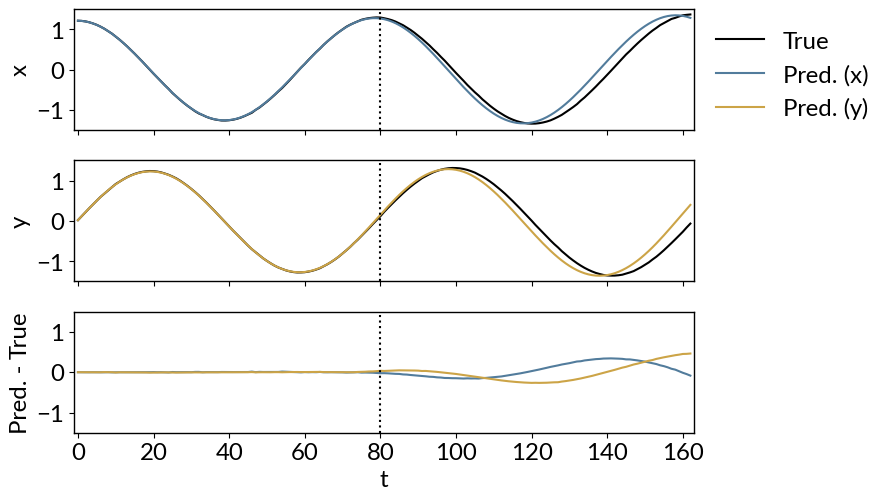

In [24]:
fig, ax = plt.subplots(3,1,figsize=(8,5.5), sharex=True)
fig.subplots_adjust(hspace=0.25)
tprops = props.copy()
tprops.set_size(props.get_size()-2)
ax[0].plot(y_batch.squeeze()[:,0].cpu(), color='black', label='True')
ax[0].plot(y_pred.squeeze()[:,0].cpu(), color='#527C9C', label='Pred. (x)')
ax[0].set_xlim([-1, batch_time])
ax[0].set_ylim([-1.5, 1.5])
format_axis(ax[0], props, '', 'x', ybins=3)

ax[1].plot(y_batch.squeeze()[:,1].cpu(), color='black')
ax[1].plot(y_pred.squeeze()[:,1].cpu(), color='#CCA447', label='Pred. (y)')
ax[1].set_ylim([-1.5, 1.5])
format_axis(ax[1], props, '', 'y', ybins=3)

y_err_x = y_pred.squeeze()[:,0].cpu() - y_batch.squeeze()[:,0].cpu()
y_err_y = y_pred.squeeze()[:,1].cpu() - y_batch.squeeze()[:,1].cpu()
ax[2].plot(y_err_x, color='#527C9C')
ax[2].plot(y_err_y, color='#CCA447')
ax[2].set_ylim([-1.5, 1.5])
format_axis(ax[2], props, 't', 'Pred. - True', ybins=3)

ax[0].axvline(max_time, color='black', ls=':')
ax[1].axvline(max_time, color='black', ls=':')
ax[2].axvline(max_time, color='black', ls=':')

ax[0].legend(frameon=False, prop=props, loc='upper left', bbox_to_anchor=(1.,1.))
ax[1].legend(frameon=False, prop=props, loc='upper left', bbox_to_anchor=(1.,1.7))
#fig.savefig(image_path + 'traj_trajectory.svg', bbox_inches='tight', transparent=True)